In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS
from efgpnd import EFGPND
import time

np.random.seed(1)

In [2]:
%load_ext autoreload
%autoreload 2

# Generate synthetic data

In [43]:
# --- Parameters ---
n = 10_000  # Number of points
d = 1  # Dimensionality of the input space
true_length_scale =0.25
true_variance = 1
true_noise_variance = (0.1)**2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
x, _ = torch.sort(x, dim=0)

Using device: cpu


In [44]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 20
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

In [45]:
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
samples_se = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
)
# For Matern kernel
samples_m32 = sample_gp_matern(
    x,
    nu=1.5,  # 3/2 Matern
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
)
y = samples_se
# y = samples_m32

# remove samples from the middle
inds_to_keep = np.concatenate([np.arange(n//2 - n // 10), np.arange(n // 2 + n // 10, n)])
x = x[inds_to_keep]
y = y[inds_to_keep]
n = torch.numel(x)

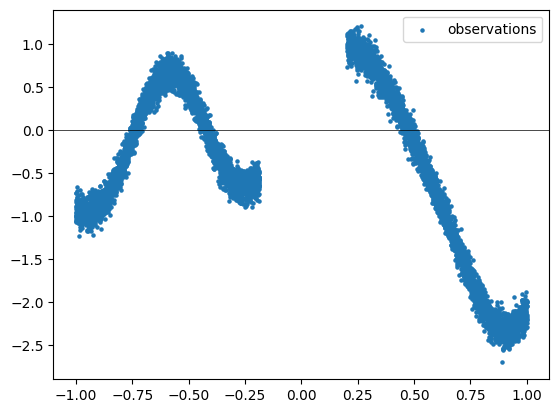

In [46]:
plt.scatter(x, y, s=5, label='observations')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.show()

## Hyperparameter learning with EFGP

In [47]:
d = 1
EPSILON = 1e-4 # bound on kernel error
cg_tol = EPSILON

In [48]:
max_iters = 100
J = 30
model = EFGPND(x, y, kernel="SquaredExponential", eps=EPSILON)
# params = next(model.parameters())
# Fix the variance parameter
fixed_variance = 1.0  # Set your desired fixed variance value
model.kernel.set_hyper('variance', fixed_variance)

optimizer = Adam(model.parameters(), lr=0.1)

for it in range(max_iters):
    optimizer.zero_grad()
    # saves grads in model._gp_params so that we can step
    model.compute_gradients(trace_samples=J, cg_tol = EPSILON / 100)
    # model.compute_gradients(trace_samples=10,cg_tol = 1e-10)

    optimizer.step()

    if it % 10 == 0:
        lengthscale = model.kernel.get_hyper('lengthscale')
        variance = model.kernel.get_hyper('variance')
        sigmasq = model._gp_params.sig2.item()
        # Get current values for printing
        print(f"[ε={EPSILON} | J={J}] iter {it:>3}  "
              f"ℓ={lengthscale:.4g}  "
              f"σ_f²={variance:.4g}  σ_n²={sigmasq:.4g}")

# Final gradient
final_grad_norms = {}
total_final_grad_norm = 0.0
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        final_grad_norms[name] = grad_norm
        total_final_grad_norm += grad_norm**2

total_final_grad_norm = np.sqrt(total_final_grad_norm)

# Final hyperparameters
lengthscale = model.kernel.get_hyper('lengthscale')
variance = model.kernel.get_hyper('variance')
sigmasq = model._gp_params.sig2.item()

print(f"Final hyperparameters: ℓ={lengthscale:.4g}, σ_f²={variance:.4g}, σ_n²={sigmasq:.4g}")

[ε=0.0001 | J=30] iter   0  ℓ=0.2855  σ_f²=1.105  σ_n²=0.1729
[ε=0.0001 | J=30] iter  10  ℓ=0.2258  σ_f²=1.247  σ_n²=0.06384
[ε=0.0001 | J=30] iter  20  ℓ=0.2639  σ_f²=1.064  σ_n²=0.02439
[ε=0.0001 | J=30] iter  30  ℓ=0.2499  σ_f²=1.405  σ_n²=0.01085
[ε=0.0001 | J=30] iter  40  ℓ=0.2814  σ_f²=1.78  σ_n²=0.007536
[ε=0.0001 | J=30] iter  50  ℓ=0.2497  σ_f²=1.417  σ_n²=0.008631
[ε=0.0001 | J=30] iter  60  ℓ=0.1693  σ_f²=2.169  σ_n²=0.01041
[ε=0.0001 | J=30] iter  70  ℓ=0.1873  σ_f²=2.45  σ_n²=0.01048
[ε=0.0001 | J=30] iter  80  ℓ=0.2603  σ_f²=2.393  σ_n²=0.009758
[ε=0.0001 | J=30] iter  90  ℓ=0.2948  σ_f²=2.186  σ_n²=0.009568
Final hyperparameters: ℓ=0.2497, σ_f²=2.06, σ_n²=0.009777


## posterior mean with learned hyperparameters

In [49]:
nnew = 1000
x_new = torch.linspace(-1, 1, nnew).unsqueeze(-1).double()
start_time = time.time()
mean_no_var, _= model.predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds; x_new.shape = {x_new.shape}")

Time without variance: 0.0151 seconds; x_new.shape = torch.Size([1000, 1])


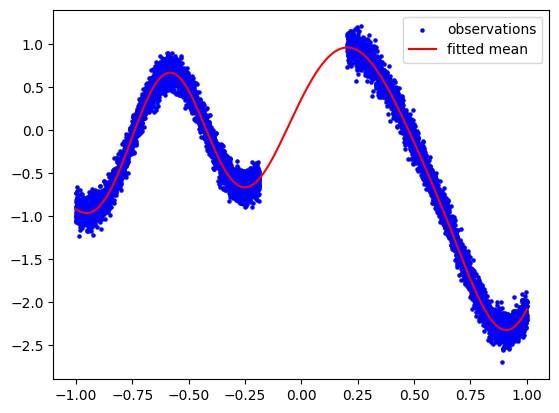

In [50]:
plt.scatter(x, y, s=5, color='blue', label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')
plt.legend()
plt.show()

## Sample from GP with learned hyperparameters

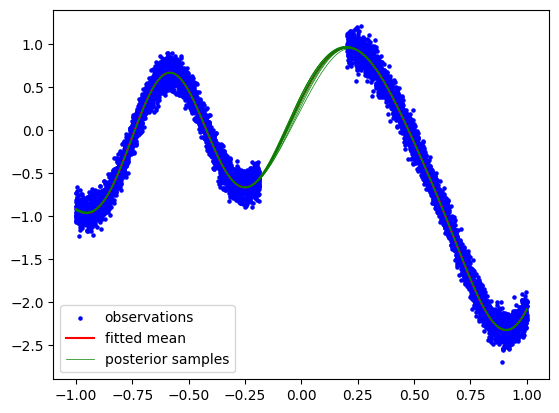

In [51]:
nnew = 1000
x_new = torch.linspace(-1, 1, nnew).unsqueeze(-1).double()
mean_no_var, _= model.predict(x_new, return_variance=False)

nsamples = 10
samples = model.sample_posterior(x_new, nsamples)

plt.scatter(x, y, s=5, color='blue', label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')

# Plot first sample with label, rest without labels
linewidth = 0.5
plt.plot(x_new, samples[:, 0], color='green', linewidth=linewidth, label='posterior samples')
for i in range(1, nsamples):
    plt.plot(x_new, samples[:, i], color='green', linewidth=linewidth)  # No label

plt.legend()
plt.show()

## Posterior variance -- Stochastic Estimate

In [53]:
start_time = time.time()
hutchinson_probes = 1000
mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")

Time with stochastic variance, x_new.shape = torch.Size([1000, 1]), 1000 probes: 0.0828 seconds


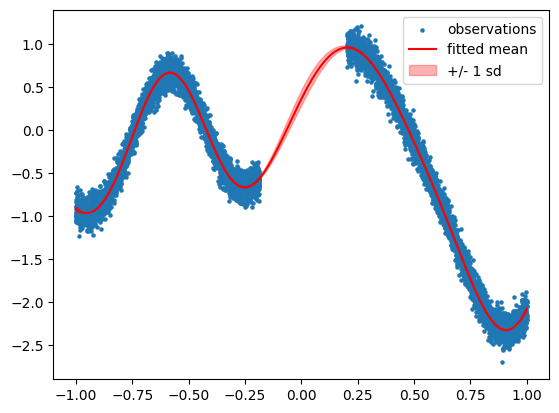

In [54]:
plt.scatter(x, y, s=5, label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')

# Add +/- 1sd
stoch_sd = torch.sqrt(stoch_var)
plt.fill_between(x_new.ravel(), mean_no_var - 2 * stoch_sd, mean_no_var + 2 * stoch_sd,
                 alpha=0.3, color='red', label='+/- 1 sd')

plt.legend()
plt.show()

## Posterior variance -- regular method

In [55]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

Time with regular variance, x_new.shape = torch.Size([1000, 1]): 0.0713 seconds


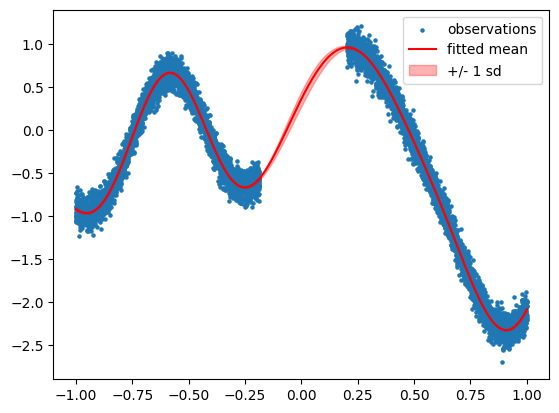

In [56]:
sd = torch.sqrt(var)
plt.scatter(x, y, s=5, label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')

# Add confidence bands
plt.fill_between(x_new.ravel(), mean_no_var - 2 * sd, mean_no_var + 2 * sd,
                 alpha=0.3, color='red', label='+/- 1 sd')

plt.legend()
plt.show()

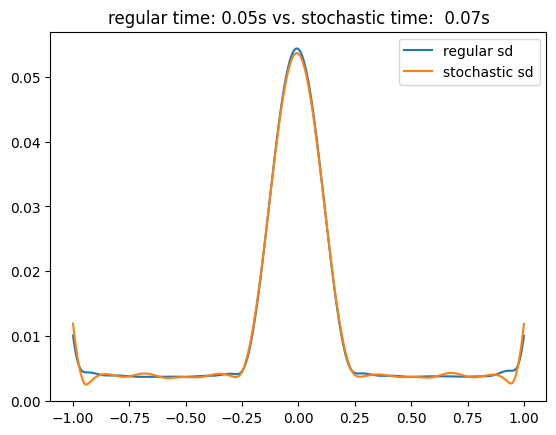

In [20]:
plt.plot(x_new, sd, label='regular sd')
plt.plot(x_new, stoch_sd, label='stochastic sd')
plt.legend()
plt.title(f'regular time: {reg_var_time:.2f}s vs. stochastic time: {stoch_var_time: .2f}s')
plt.show()